In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider
from IPython.display import display

In [58]:
R = 8.314 #J⋅K−1⋅mol−1
sigma_water = 72* 1e-3 # N m-1
mv = 18 * 1e-3 # Kg mol-1
rho_w = 1000 # Kg m-3
# D = np.linspace(0.05*1e-6, 0.65 * 1e-6, 100 ) # m, wet diameter 5e-8, 

In [59]:
T = widgets.FloatSlider(min=250, max=300, step=0.01, value=288.15, description = 'Temperature') # K
D= widgets.IntRangeSlider(min=1, max = 100, value = [5, 65], description = 'Wet Diameter') # need time 1e-8
d_0 = widgets.FloatSlider(min=40, max=200, step=1, value=41,description='dry diameter') # nm
frac_org = widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5, description='organic fraction') 
delta_min = widgets.FloatSlider(min=0.1, max=0.3, step=0.01, value=0.16, description='delta_min') # nm
sigma_inorganic = widgets.Dropdown(options=[('AS', 228), ('H2SO4', 49)], description='sigma_inorganic:') # mN/m
kappa_inorganic = widgets.Dropdown(options= [('AS', 0.58), ('H2SO4', 0.7)], description='kappa_inorganic')
sigma_organic= widgets.Dropdown(options= [('system2', 30)], description='sigma_organic') # mN/m
kappa_organic= widgets.Dropdown(options= [('system2', 0.01)], description='kappa_organic')

display(T, D, d_0, frac_org, delta_min, sigma_inorganic, kappa_inorganic, sigma_organic, kappa_organic)

FloatSlider(value=288.15, description='Temperature', max=300.0, min=250.0, step=0.01)

IntRangeSlider(value=(5, 65), description='Wet Diameter', min=1)

FloatSlider(value=41.0, description='dry diameter', max=200.0, min=40.0, step=1.0)

FloatSlider(value=0.5, description='organic fraction', max=1.0, step=0.01)

FloatSlider(value=0.16, description='delta_min', max=0.3, min=0.1, step=0.01)

Dropdown(description='sigma_inorganic:', options=(('AS', 228), ('H2SO4', 49)), value=228)

Dropdown(description='kappa_inorganic', options=(('AS', 0.58), ('H2SO4', 0.7)), value=0.58)

Dropdown(description='sigma_organic', options=(('system2', 30),), value=30)

Dropdown(description='kappa_organic', options=(('system2', 0.01),), value=0.01)

In [60]:
Dw = np.linspace(D.value[0]*1e-8, D.value[1]*1e-8,100)

def S_const_sigma(Dw):
    A_cs = (4 * sigma_water * mv)/(R * T.value * rho_w)
    kappa_cs = (1 - frac_org.value) * kappa_inorganic.value + frac_org.value * kappa_organic.value
    return (Dw ** 3 - ((d_0.value)*1e-9)**3)/(Dw ** 3 - (1-kappa_cs)*((d_0.value)*1e-9)**3)*np.exp(A_cs/Dw )

def S_varying_sigma(Dw):
    v_wet = (np.pi * Dw **3)/6
    v_dry = (np.pi * ((d_0.value)*1e-9)**3)/6
    # calculate the minimum shell volume, v_delta
    v_delta = v_wet - (((4 * np.pi) / 3) * (Dw /2 - delta_min.value * 1e-9) ** 3)
    # calculate the total volume of organic, v_beta
    v_beta = frac_org.value * v_dry                                                               
    # calculate the coverage parameter
    c_beta = np.minimum(v_beta / v_delta, 1)                                                   
    f_core_water = ((Dw - 2 * delta_min.value * 1e-9) ** 3 - ((d_0.value) * 1e-9) ** 3)/(Dw - 2 * delta_min.value * 1e-9) ** 3
    f_core_inorganic = 1 - f_core_water
    sigma_core = f_core_water * sigma_water + f_core_inorganic * sigma_inorganic.value * 1e-3
    sigma_shell = sigma_organic.value * 1e-3
    # calculate overall sigma
    sigma = (1 - c_beta) * sigma_core + c_beta * sigma_shell                                    
    A = (4* sigma * mv)/(R * T.value * rho_w)
    kappa_final = (1 - frac_org.value) * kappa_inorganic.value + frac_org.value * kappa_organic.value
    return ((Dw ** 3 - ((d_0.value) * 1e-9) ** 3)/(Dw ** 3 - (1-kappa_final) * ((d_0.value) * 1e-9) ** 3)) * np.exp(A/Dw )

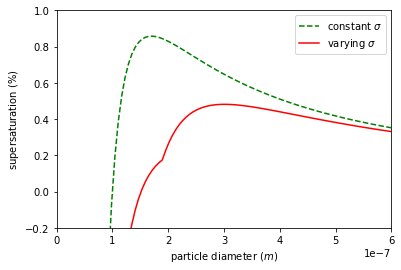

In [61]:
plt.plot(Dw, (S_const_sigma(Dw)-1)*100, 'g--', label='constant $\sigma$')
plt.plot(Dw, (S_varying_sigma(Dw)-1)*100, 'r-', label='varying $\sigma$')
plt.xlim(0, 6e-7)
plt.ylim(-0.2, 1)
plt.xlabel("particle diameter ($ m$)")
plt.ylabel("supersaturation ($\%$)")
plt.legend()

plt.savefig('varying_sigma.png')
